<span style="color: Gold"> 프론트엔드 vs 백엔드

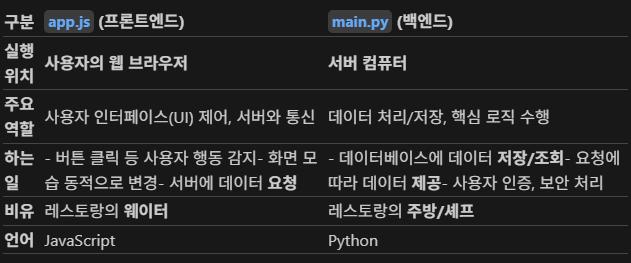

<span style="color: Gold"> 백엔드의 전체 구조

[1] 앱 설정 (서버 뼈대)  
[2] 미들웨어 / 공통 규칙  
[3] 데이터 규칙 (Model)  
[4] 라우터 (URL ↔ 함수 연결)  
[5] 비즈니스 로직 (실제 처리)  

<span style="color: Gold"> Body / Path / Query 비교

- Path	“누구를 대상으로 할지” -> 특정 자원 하나를 정확히 지목할 때  
- Query	“조건 / 옵션” -> 조회 조건, 필터, 옵션  
- Body	“핵심 데이터” -> 새로 만들거나 수정할 데이터 그 자체  

<br>

```text
PUT /api/todos/5?notify=true
        ↑        ↑
      Path     Query
----------------------
Body:
{
  "completed": true
}
```

---

<span style="color: Gold">  main.py 파일 나눠서 설명

<span style="color: pink">1. 앱 설정 (서버 뼈대)

In [ ]:
app = FastAPI(
    title="Step 5: TODO with Frontend",
    description="HTML + jQuery 프론트엔드와 연동",
    version="5.0.0"
)

<span style="color: pink">2. 미들웨어/ 공동규칙 </span>

<span style="font-size:12px;">
- CORS 설정 -> 브라우저가 “다른 출처(origin)”로의 요청을 허용할지 말지를 결정하는 규칙

In [ ]:
app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],    # 어떤 주소에서 오는 요청이든 허용하겠다는 의미
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

<span style="color: pink">3. 데이터 규칙 (Pydantic Model)

In [ ]:
class TodoCreate(BaseModel):    # 클라이언트가 '할일 생성'을 요청할 때 title과 description을 보내야 한다는 규칙
    title: str = Field(..., min_length=1, max_length=200)
    description: Optional[str] = Field(None, max_length=1000)

class TodoUpdate(BaseModel):
    title: Optional[str] = Field(None, min_length=1, max_length=200)
    description: Optional[str] = Field(None, max_length=1000)
    completed: Optional[bool] = None

class TodoResponse(BaseModel):  # 서버가 클라이언트에게 응답을 보낼 때, 아래와 같은 정보를 포함해야 한다는 규칙
    id: int
    title: str
    description: Optional[str]
    completed: bool
    created_at: str

<span style="color: pink">4. 라우터 (URL ↔ 함수 연결)

In [ ]:
@app.post("/api/todos", response_model=TodoResponse, status_code=status.HTTP_201_CREATED)
def create_todo(todo: TodoCreate):
    """TODO 추가"""
    global next_id
    
    new_todo = {
        "id": next_id,
        "title": todo.title,
        "description": todo.description,
        "completed": False,
        "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    }
    
    todos_db.append(new_todo)
    next_id += 1
    
    print(f"[CREATE] TODO 추가: {new_todo['title']}")
    return new_todo

# 모든 할일 목록(todos_db)을 조회하여 반환
@app.get("/api/todos", response_model=list[TodoResponse])
def get_all_todos():
    """TODO 목록 조회"""
    print(f"[READ] TODO 조회: {len(todos_db)}개")
    return todos_db


@app.get("/api/todos/{todo_id}", response_model=TodoResponse)
def get_todo(todo_id: int):
    """특정 TODO 조회"""
    for todo in todos_db:
        if todo["id"] == todo_id:
            return todo
    
    raise HTTPException(
        status_code=status.HTTP_404_NOT_FOUND,
        detail=f"ID {todo_id}인 TODO를 찾을 수 없습니다"
    )


@app.put("/api/todos/{todo_id}", response_model=TodoResponse)
def update_todo(todo_id: int, todo_update: TodoUpdate):
    """TODO 수정"""
    for todo in todos_db:
        if todo["id"] == todo_id:
            if todo_update.title is not None:
                todo["title"] = todo_update.title
            if todo_update.description is not None:
                todo["description"] = todo_update.description
            if todo_update.completed is not None:
                todo["completed"] = todo_update.completed
            
            print(f"[UPDATE] TODO 수정: ID={todo_id}")
            return todo
    
    raise HTTPException(
        status_code=status.HTTP_404_NOT_FOUND,
        detail=f"ID {todo_id}인 TODO를 찾을 수 없습니다"
    )


@app.delete("/api/todos/{todo_id}", status_code=status.HTTP_204_NO_CONTENT)
def delete_todo(todo_id: int):
    """TODO 삭제"""
    for index, todo in enumerate(todos_db):
        if todo["id"] == todo_id:
            todos_db.pop(index)
            print(f"[DELETE] TODO 삭제: ID={todo_id}")
            return
    
    raise HTTPException(
        status_code=status.HTTP_404_NOT_FOUND,
        detail=f"ID {todo_id}인 TODO를 찾을 수 없습니다"
    )


@app.get("/api/health")
def health_check():
    """서버 상태 및 통계"""
    total = len(todos_db)
    completed = len([t for t in todos_db if t["completed"]])
    pending = total - completed
    
    return {
        "status": "healthy",
        "total": total,
        "completed": completed,
        "pending": pending
    }

<span style="color: pink">5.비즈니스 로직 (실제 처리)  

<span style="font-size:12px;">

- 이 프로그램이 실제로 ‘무엇을 하기로 되어 있는가’에 대한 규칙  
- 우리 코드에서는 라우터에 섞여있음

In [ ]:
new_todo = {
    "id": next_id,
    "title": todo.title,
    "description": todo.description,
    "completed": False,
    "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
}

todos_db.append(new_todo)
next_id += 1